In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



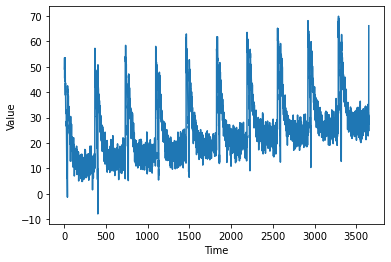

In [7]:
def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)
    plt.show()

def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time<0.1,
                    np.cos(season_time*6*np.pi),
                    2/np.exp(9*season_time))

def seasonality(time, period, amplitude, phase=0):
    season_time = ((time+phase)%period) / period
    return amplitude* seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

time = np.arange(10*365+1, dtype='float32')
baseline = 10
amplitude=40
slope=0.005
noise_level = 3
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 16s 21ms/step - loss: 20.3828 - mae: 20.8828

(1e-08, 0.0001, 0.0, 30.0)

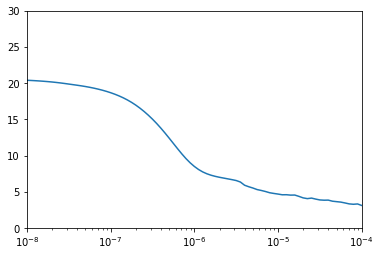

In [5]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*10.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(dataset, epochs=100)


Epoch 1/100
94/94 [==============================] - 7s 19ms/step - loss: 9.5128 - mae: 9.9985

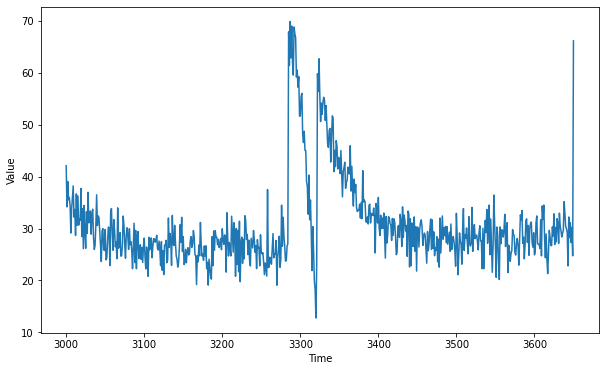

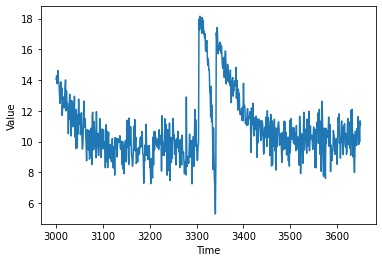

In [9]:
forecast = []
results = []

for time in range(len(series)-window_size):
    forecast.append(model.predict(series[time:time+window_size])[np.newaxis])

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, results)

<tf.Tensor: shape=(651,), dtype=float32, numpy=
array([16.596064 , 16.365582 , 16.881414 , 16.518385 , 16.033958 ,
       16.80309  , 16.824759 , 17.462263 , 18.160408 , 17.89144  ,
       16.7631   , 17.889935 , 17.1555   , 18.93915  , 18.009531 ,
       17.74598  , 17.747423 , 18.45811  , 18.093227 , 17.111492 ,
       16.637096 , 18.646292 , 17.355122 , 18.2686   , 18.145674 ,
       18.589243 , 20.13113  , 18.733862 , 18.172796 , 17.568293 ,
       19.20762  , 18.784697 , 20.276573 , 17.963598 , 19.679207 ,
       18.061893 , 19.665472 , 19.313318 , 19.3843   , 17.694546 ,
       20.342728 , 18.742577 , 21.087738 , 18.565763 , 20.088629 ,
       21.057068 , 18.905699 , 20.151886 , 17.882542 , 19.536198 ,
       19.05676  , 18.869581 , 20.197613 , 18.996155 , 18.7699   ,
       20.368256 , 21.13032  , 20.886131 , 19.689625 , 18.010107 ,
       19.69454  , 19.139666 , 19.226574 , 20.035955 , 20.862907 ,
       21.890285 , 19.991686 , 19.864485 , 21.1371   , 21.19337  ,
       19.9179

<Figure size 432x288 with 0 Axes>

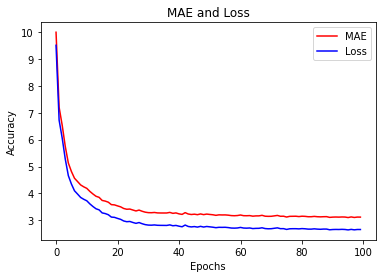

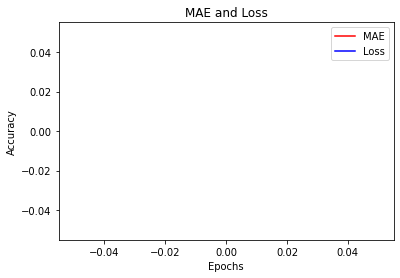

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()